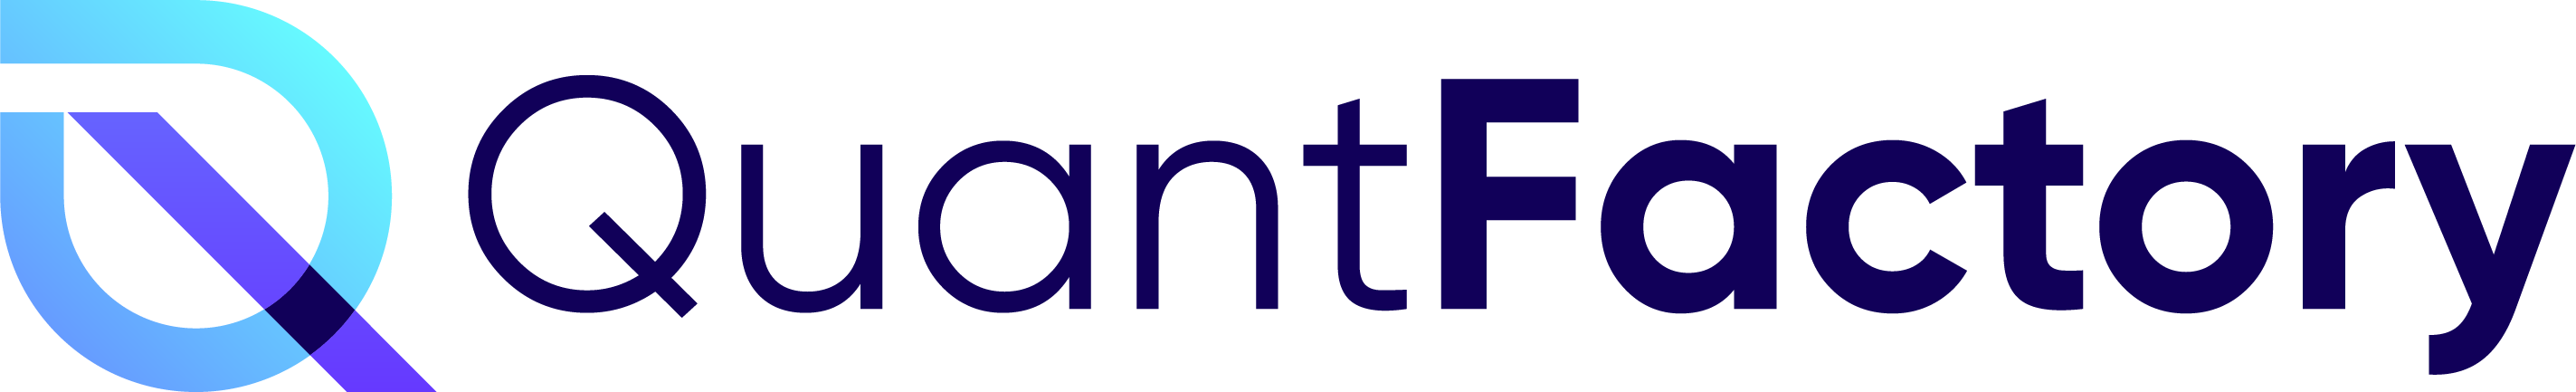

# Loading Packages and Downloading Stock Prices

In [3]:
import warnings
warnings.filterwarnings('ignore')
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, moment
from numpy.linalg import LinAlgError
import pandas_datareader.data as web
import statsmodels.tsa.api as tsa
import matplotlib.pyplot as plt
from itertools import product
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import yfinance as yf
sns.set_style('whitegrid')

stock_df = yf.download(tickers='NVDA', start='2012-01-01', end='2023-01-29')

nvda_log = np.log(stock_df['Adj Close']).diff().dropna()

nvda_log

[*********************100%***********************]  1 of 1 completed


Date
2012-01-04    0.011331
2012-01-05    0.035285
2012-01-06   -0.011624
2012-01-09    0.000000
2012-01-10   -0.004135
                ...   
2023-01-23    0.073159
2023-01-24    0.003744
2023-01-25    0.003006
2023-01-26    0.024487
2023-01-27    0.028035
Name: Adj Close, Length: 2785, dtype: float64

In [4]:
def plot_correlogram(x, lags=None, title=None):
    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    
    x.plot(ax=axes[0][0], title='Residuals')
    
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    
    probplot(x, plot=axes[0][1])
    
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    
    axes[1][0].set_xlabel('Lag')
    
    axes[1][1].set_xlabel('Lag')
    
    fig.suptitle(title, fontsize=14)
    
    sns.despine()
    
    fig.tight_layout()
    
    fig.subplots_adjust(top=.9)
    
    return

# Visualizing Daily Volatility Correlogram

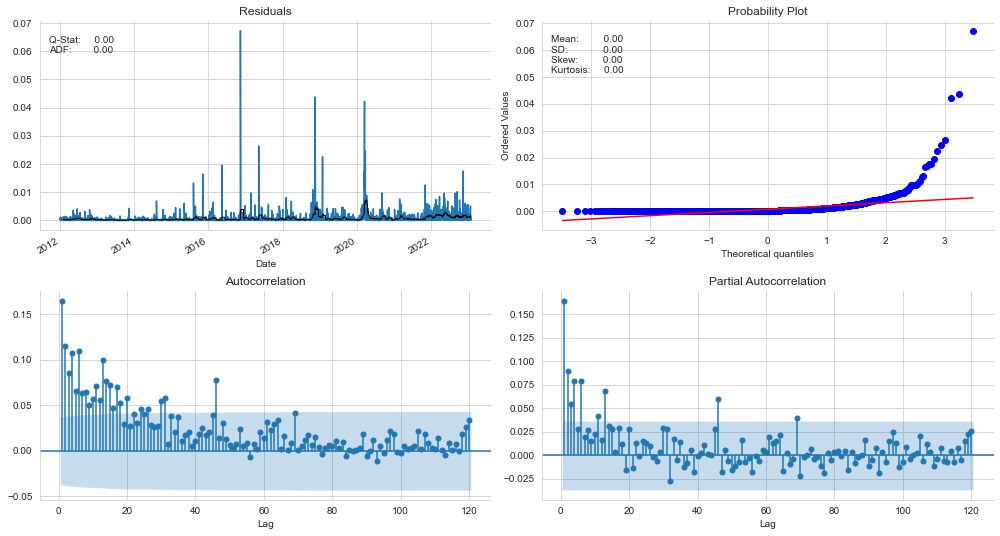

In [5]:
nvda_daily_vol = (nvda_log-nvda_log.mean())**2

plot_correlogram(x=nvda_daily_vol,
                 lags=120,
                 title=None)

In [6]:
from arch import arch_model

trainsize = 10 * 252

data = nvda_log.clip(lower=nvda_log.quantile(.05),
                     upper=nvda_log.quantile(.95))

T = len(nvda_log)

results = {}

for p in range(1, 5):
    
    for q in range(1, 5):
        
        print(f'{p} | {q}')

        result = []

        for s, t in enumerate(range(trainsize, T-1)):

            train_set = data.iloc[s:t]

            test_set = data.iloc[t+1]

            model = arch_model(y=train_set, p=p, q=q).fit(disp='off')

            forecast = model.forecast(horizon=1)

            mu = forecast.mean.iloc[-1, 0]

            var = forecast.variance.iloc[-1, 0]

            result.append([(test_set-mu)**2, var])

        df = pd.DataFrame(result, columns=['y_true', 'y_pred'])

        results[(p, q)] = np.sqrt(mean_squared_error(df.y_true, df.y_pred))

1 | 1
1 | 2
1 | 3
1 | 4
2 | 1
2 | 2
2 | 3
2 | 4
3 | 1
3 | 2
3 | 3
3 | 4
4 | 1
4 | 2
4 | 3
4 | 4


In [7]:
results

{(1, 1): 0.0007350470371337498,
 (1, 2): 0.0007325441891786562,
 (1, 3): 0.0007323116984633037,
 (1, 4): 0.0007312346775747097,
 (2, 1): 0.0007332811791716178,
 (2, 2): 0.000729585403702521,
 (2, 3): 0.0007292772428547907,
 (2, 4): 0.0007303215613147918,
 (3, 1): 0.0007317851322316082,
 (3, 2): 0.0007275592246159361,
 (3, 3): 0.0007267490751792652,
 (3, 4): 0.0007271976301234526,
 (4, 1): 0.0007311402415397573,
 (4, 2): 0.0007261488245288741,
 (4, 3): 0.0007244458474866348,
 (4, 4): 0.0007324077421200897}

In [8]:
pd.DataFrame(results, index=pd.Series(0)).unstack().idxmin()

(4, 3, 0)

In [9]:
data = nvda_log.clip(lower=nvda_log.quantile(.05),
                     upper=nvda_log.quantile(.95))

best_model = arch_model(y=data, p=4, q=2).fit(update_freq=5, disp='off')

print(best_model.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                6938.09
Distribution:                  Normal   AIC:                          -13860.2
Method:            Maximum Likelihood   BIC:                          -13812.7
                                        No. Observations:                 2785
Date:                Tue, Jan 31 2023   Df Residuals:                     2784
Time:                        09:34:40   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.5453e-03  3.577e-04      4.319  1.565e-05 [8.

In [10]:
data = nvda_log.to_frame('nvda_log_ret')

data['variance'] = data['nvda_log_ret'].rolling(70).var()

data = data['2020':]

def predict_volatility(x):  
    
    best_model = arch_model(y=x, p=3, q=3).fit(update_freq=5, disp='off')
    
    variance_forecast = best_model.forecast(horizon=1).variance.iloc[-1, 0]
    
    print(x.index[-1])
    
    return variance_forecast

data['predictions'] = data['nvda_log_ret'].rolling(70).apply(lambda x: predict_volatility(x))

data = data.dropna()

data

2020-04-13 00:00:00
2020-04-14 00:00:00
2020-04-15 00:00:00
2020-04-16 00:00:00
2020-04-17 00:00:00
2020-04-20 00:00:00
2020-04-21 00:00:00
2020-04-22 00:00:00
2020-04-23 00:00:00
2020-04-24 00:00:00
2020-04-27 00:00:00
2020-04-28 00:00:00
2020-04-29 00:00:00
2020-04-30 00:00:00
2020-05-01 00:00:00
2020-05-04 00:00:00
2020-05-05 00:00:00
2020-05-06 00:00:00
2020-05-07 00:00:00
2020-05-08 00:00:00
2020-05-11 00:00:00
2020-05-12 00:00:00
2020-05-13 00:00:00
2020-05-14 00:00:00
2020-05-15 00:00:00
2020-05-18 00:00:00
2020-05-19 00:00:00
2020-05-20 00:00:00
2020-05-21 00:00:00
2020-05-22 00:00:00
2020-05-26 00:00:00
2020-05-27 00:00:00
2020-05-28 00:00:00
2020-05-29 00:00:00
2020-06-01 00:00:00
2020-06-02 00:00:00
2020-06-03 00:00:00
2020-06-04 00:00:00
2020-06-05 00:00:00
2020-06-08 00:00:00
2020-06-09 00:00:00
2020-06-10 00:00:00
2020-06-11 00:00:00
2020-06-12 00:00:00
2020-06-15 00:00:00
2020-06-16 00:00:00
2020-06-17 00:00:00
2020-06-18 00:00:00
2020-06-19 00:00:00
2020-06-22 00:00:00


C:\Users\user\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2021-03-03 00:00:00
2021-03-04 00:00:00
2021-03-05 00:00:00


C:\Users\user\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2021-03-08 00:00:00
2021-03-09 00:00:00
2021-03-10 00:00:00
2021-03-11 00:00:00
2021-03-12 00:00:00
2021-03-15 00:00:00
2021-03-16 00:00:00
2021-03-17 00:00:00
2021-03-18 00:00:00
2021-03-19 00:00:00
2021-03-22 00:00:00
2021-03-23 00:00:00
2021-03-24 00:00:00
2021-03-25 00:00:00
2021-03-26 00:00:00
2021-03-29 00:00:00
2021-03-30 00:00:00
2021-03-31 00:00:00
2021-04-01 00:00:00
2021-04-05 00:00:00
2021-04-06 00:00:00
2021-04-07 00:00:00
2021-04-08 00:00:00
2021-04-09 00:00:00
2021-04-12 00:00:00
2021-04-13 00:00:00
2021-04-14 00:00:00
2021-04-15 00:00:00
2021-04-16 00:00:00
2021-04-19 00:00:00
2021-04-20 00:00:00
2021-04-21 00:00:00
2021-04-22 00:00:00
2021-04-23 00:00:00
2021-04-26 00:00:00
2021-04-27 00:00:00
2021-04-28 00:00:00
2021-04-29 00:00:00
2021-04-30 00:00:00
2021-05-03 00:00:00
2021-05-04 00:00:00
2021-05-05 00:00:00
2021-05-06 00:00:00
2021-05-07 00:00:00
2021-05-10 00:00:00
2021-05-11 00:00:00
2021-05-12 00:00:00
2021-05-13 00:00:00
2021-05-14 00:00:00
2021-05-17 00:00:00


C:\Users\user\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2021-11-12 00:00:00
2021-11-15 00:00:00
2021-11-16 00:00:00
2021-11-17 00:00:00
2021-11-18 00:00:00
2021-11-19 00:00:00
2021-11-22 00:00:00
2021-11-23 00:00:00
2021-11-24 00:00:00


C:\Users\user\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2021-11-26 00:00:00
2021-11-29 00:00:00
2021-11-30 00:00:00
2021-12-01 00:00:00
2021-12-02 00:00:00
2021-12-03 00:00:00
2021-12-06 00:00:00


C:\Users\user\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2021-12-07 00:00:00
2021-12-08 00:00:00
2021-12-09 00:00:00
2021-12-10 00:00:00
2021-12-13 00:00:00
2021-12-14 00:00:00
2021-12-15 00:00:00
2021-12-16 00:00:00
2021-12-17 00:00:00
2021-12-20 00:00:00
2021-12-21 00:00:00
2021-12-22 00:00:00
2021-12-23 00:00:00
2021-12-27 00:00:00
2021-12-28 00:00:00
2021-12-29 00:00:00
2021-12-30 00:00:00
2021-12-31 00:00:00
2022-01-03 00:00:00
2022-01-04 00:00:00
2022-01-05 00:00:00
2022-01-06 00:00:00
2022-01-07 00:00:00
2022-01-10 00:00:00
2022-01-11 00:00:00
2022-01-12 00:00:00
2022-01-13 00:00:00
2022-01-14 00:00:00
2022-01-18 00:00:00
2022-01-19 00:00:00
2022-01-20 00:00:00
2022-01-21 00:00:00
2022-01-24 00:00:00
2022-01-25 00:00:00
2022-01-26 00:00:00
2022-01-27 00:00:00
2022-01-28 00:00:00
2022-01-31 00:00:00
2022-02-01 00:00:00
2022-02-02 00:00:00
2022-02-03 00:00:00
2022-02-04 00:00:00
2022-02-07 00:00:00
2022-02-08 00:00:00
2022-02-09 00:00:00
2022-02-10 00:00:00
2022-02-11 00:00:00
2022-02-14 00:00:00
2022-02-15 00:00:00
2022-02-16 00:00:00


,nvda_log_ret,variance,predictions
Date,,,
2020-04-13,0.025902,0.002955,0.001584
2020-04-14,0.050932,0.002985,0.002480
2020-04-15,-0.011013,0.002983,0.001363
2020-04-16,0.048173,0.003013,0.001807
2020-04-17,-0.008109,0.003013,0.001296
...,...,...,...
2023-01-23,0.073159,0.001440,0.001742
2023-01-24,0.003744,0.001437,0.001298
2023-01-25,0.003006,0.001422,0.001281


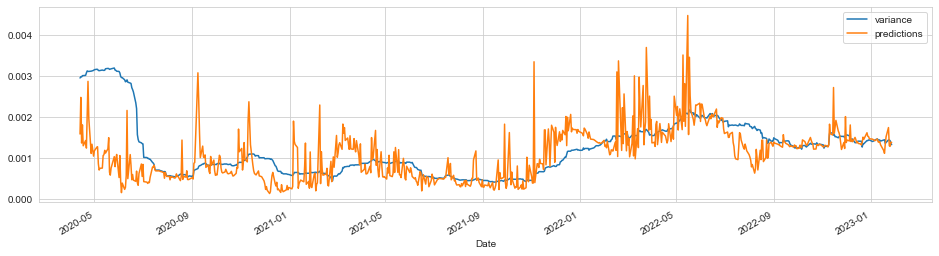

In [11]:
data[['variance', 'predictions']].plot(figsize=(16,4))

plt.show()

In [12]:
from pykalman import KalmanFilter

def KalmanFilterAverage(x):
    kf = KalmanFilter(transition_matrices = [1],
                      observation_matrices = [1],
                      initial_state_mean = 0,
                      initial_state_covariance = 1,
                      observation_covariance=1,
                      transition_covariance=.01)
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means

data['fixed_predictions'] = KalmanFilterAverage(data['predictions'])

data

,nvda_log_ret,variance,predictions,fixed_predictions
Date,,,,
2020-04-13,0.025902,0.002955,0.001584,0.000792
2020-04-14,0.050932,0.002985,0.002480,0.001362
2020-04-15,-0.011013,0.002983,0.001363,0.001363
2020-04-16,0.048173,0.003013,0.001807,0.001457
2020-04-17,-0.008109,0.003013,0.001296,0.001428
...,...,...,...,...
2023-01-23,0.073159,0.001440,0.001742,0.001423
2023-01-24,0.003744,0.001437,0.001298,0.001412
2023-01-25,0.003006,0.001422,0.001281,0.001399


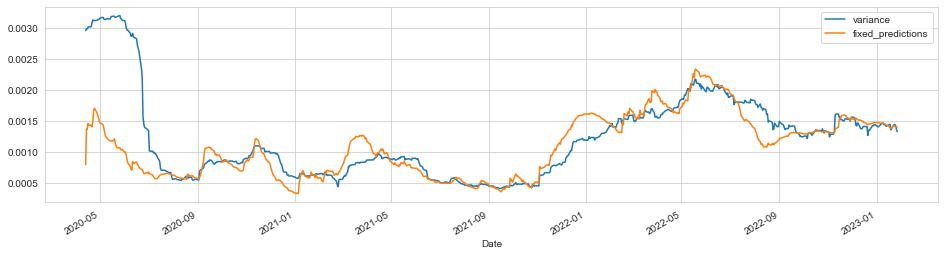

In [13]:
data[['variance', 'fixed_predictions']].plot(figsize=(16,4))

plt.show()

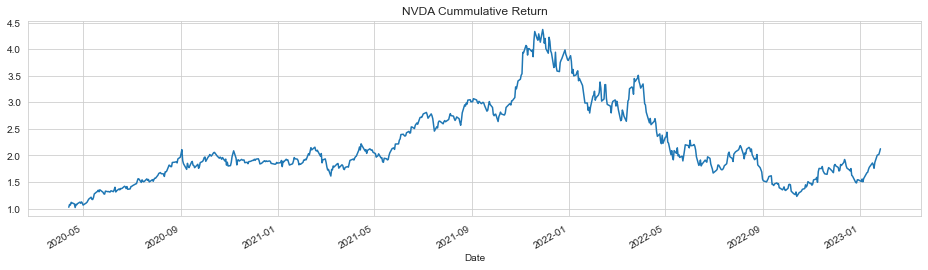

In [14]:
np.exp(np.log1p(data['nvda_log_ret']).cumsum()).plot(figsize=(16,4))

plt.title('NVDA Cummulative Return')

plt.show()

In [15]:
print(f"Sharpe Ratio NVDA: {(data['nvda_log_ret'].mean()/data['nvda_log_ret'].std())*(252**.5)}")

Sharpe Ratio NVDA: 0.7783535725663184


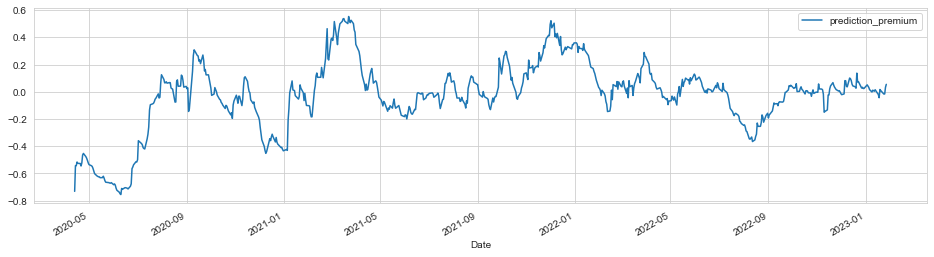

In [16]:
data['prediction_premium'] = (data['fixed_predictions']-data['variance'])/data['variance']

data[['prediction_premium']].plot(figsize=(16,4))

plt.show()

In [20]:
data['premium_diff'] = data['prediction_premium'].diff()

std = data['prediction_premium'].diff().std()

data['signal'] = data.apply(lambda x: 1 if (x['prediction_premium']<0)&(x['premium_diff']>std)
                            else (-1 if (x['prediction_premium']>0)&(x['premium_diff']<-std) else np.nan), axis=1)

data['signal'] = data['signal'].ffill(limit=5)

data['strategy_return'] = (data['nvda_log_ret']*data['signal'])

data

,nvda_log_ret,variance,predictions,fixed_predictions,prediction_premium,premium_diff,signal,strategy_return
Date,,,,,,,,
2020-04-13,0.025902,0.002955,0.001584,0.000792,-0.731945,NaN,NaN,NaN
2020-04-14,0.050932,0.002985,0.002480,0.001362,-0.543643,0.188302,1.0,0.050932
2020-04-15,-0.011013,0.002983,0.001363,0.001363,-0.543188,0.000455,1.0,-0.011013
2020-04-16,0.048173,0.003013,0.001807,0.001457,-0.516497,0.026691,1.0,0.048173
2020-04-17,-0.008109,0.003013,0.001296,0.001428,-0.526229,-0.009732,1.0,-0.008109
...,...,...,...,...,...,...,...,...
2023-01-23,0.073159,0.001440,0.001742,0.001423,-0.011213,-0.019729,NaN,NaN
2023-01-24,0.003744,0.001437,0.001298,0.001412,-0.017456,-0.006243,NaN,NaN
2023-01-25,0.003006,0.001422,0.001281,0.001399,-0.016018,0.001438,NaN,NaN


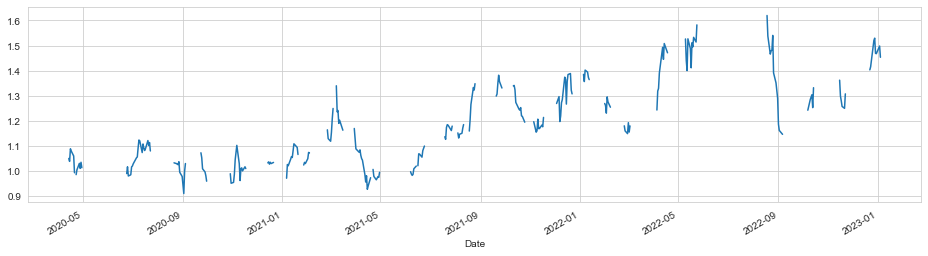

In [18]:
np.exp(np.log1p(data['strategy_return']).cumsum()).plot(figsize=(16,4))

plt.show()

In [19]:
(data['strategy_return'].mean()/data['strategy_return'].std()) * (252**.5)

0.9366284063064632